# Portfolio Assignment 4: Representational Similarity Analysis

### Set up kernel

In [1]:
import os
path='/work/student_folders/victorias_folder/notebooks_fMRI'
os.chdir(path)
!./activate.sh

Installed kernelspec virt_env in /home/ucloud/.local/share/jupyter/kernels/virt_env
Done! Remember changing the kernel in Jupyter.


### Import packages

In [38]:
import warnings
import sys 
if not sys.warnoptions:
    warnings.simplefilter("ignore")

import os
import numpy as np
import pandas as pd
import scipy.io
import scipy.spatial.distance as sp_distance
import matplotlib.pyplot as plt
import seaborn as sns 

from scipy import stats
from scipy.stats import kendalltau
from scipy.spatial.distance import squareform
from sklearn.metrics import pairwise_distances
from sklearn.manifold import MDS
from mpl_toolkits.mplot3d import Axes3D
from utils import load_data_for_a_subj, digitize_rdm, ns_data_dir

# %matplotlib notebook
%matplotlib inline
%autosave 5
sns.set(style = 'white', context='poster', rc={"lines.linewidth": 2.5})
sns.set(palette="colorblind")

Autosaving every 5 seconds


### Optional: Load in dataset
Uncomment if the data is not currenly loaded in

In [2]:
#!cd /work/notebooks_fMRI/data/; wget -q --show-progress --no-check-certificate -r 'https://drive.google.com/uc?export=download&confirm=Yqoe&id=14m-YY-N3mCjCdHGkeVlTS4uA7WJzbQS0' -O 'NinetySix.zip'
#!cd /work/notebooks_fMRI/data/; unzip NinetySix.zip

### Load in the data from one subject
This analysis will be focused on subject "SN"

In [2]:
# Load the data for one subject
subj_initials = 'SN'
ns_data_dir = os.path.join('/work/notebooks_fMRI/data', 'NinetySix')

all_subj_initials = {'BE', 'KO', 'SN', 'TI'}
rois_to_remove = ['lLO', 'rLO']
#FFA: Fusiform Face Area. PPA: Parahippocampal Place Area 
rois_to_keep = ['lFFA', 'rFFA', 'lPPA', 'rPPA']

def load_data_for_a_subj(subj_initials):
    assert subj_initials in all_subj_initials
    images = scipy.io.loadmat(
        os.path.join(ns_data_dir, '%s_images.mat' % (subj_initials))
    )['images']  
    data = scipy.io.loadmat(
        os.path.join(ns_data_dir, '%s_roi_data.mat' % (subj_initials))
    ) 
    
    # Unpack metadata 
    roi_data_all = data['roi_data']
    roi_names = data['roinames']
    labels = np.array(data['labels'])
    categoryNames = data['categoryNames']

    # Re-format metadata labels and ROIs
    n_categories = categoryNames.shape[1]
    n_rois = roi_names.shape[1]
    categories = [categoryNames[0, i][0] for i in range(n_categories)]
    roi_names = [roi_names[0, i][0] for i in range(n_rois)]
    labels = np.squeeze(labels) 
    label_dict = {categories[i]: i+1 for i in range(len(categories))}

    # Remove r/lLO
    roi_data = []
    for r in range(n_rois): 
        if roi_names[r] in rois_to_keep: 
            roi_data.append(roi_data_all[0, r])
    roi_names = rois_to_keep
    n_rois = len(rois_to_keep)
    return images, roi_data, roi_names, n_rois, categories, n_categories, labels, label_dict


data_pack = load_data_for_a_subj(subj_initials)
images, roi_data, roi_names, n_rois, categories, n_categories, labels, label_dict = data_pack
n_stimuli = len(images)

### Inspect and visualize the data

Each row is a trial, each column is a voxel in the ROI

In [3]:
# Inspecting the data
print('ROI names:',roi_names)
print('Stimulus categories:', categories)
print(type(labels))
print('Trial labels:', labels)
print('Region of interest matrix sizes:')
for roi in roi_data:
    print (roi.shape)

ROI names: ['lFFA', 'rFFA', 'lPPA', 'rPPA']
Stimulus categories: ['artificial inanimate', 'human bodypart', 'human face', 'natural inanimate', 'nonhuman bodypart', 'nonhuman face']
<class 'numpy.ndarray'>
Trial labels: [2 2 2 2 2 2 2 2 2 2 2 2 3 3 3 3 3 3 3 3 3 3 3 3 5 5 5 5 5 5 5 5 5 5 5 5 6
 6 6 6 6 6 6 6 6 6 6 6 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
Region of interest matrix sizes:
(96, 37)
(96, 145)
(96, 135)
(96, 112)


Text(0, 0.5, 'Stimulus category')

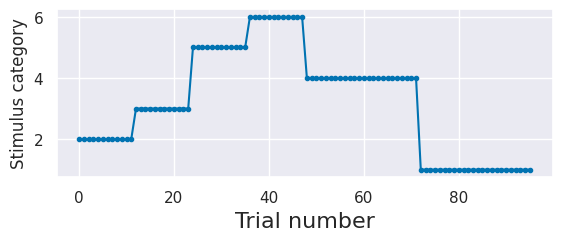

In [4]:
# Plotting stimulus categories
plt.figure()

# Label plot
plt.subplot(2,1,2)
plt.plot(labels,'.-')
plt.xlabel('Trial number', fontsize=16)
plt.ylabel('Stimulus category', fontsize=12)

In [5]:
# Looking further at the ROIs
print('ROI names: ', roi_names)

ROI names:  ['lFFA', 'rFFA', 'lPPA', 'rPPA']


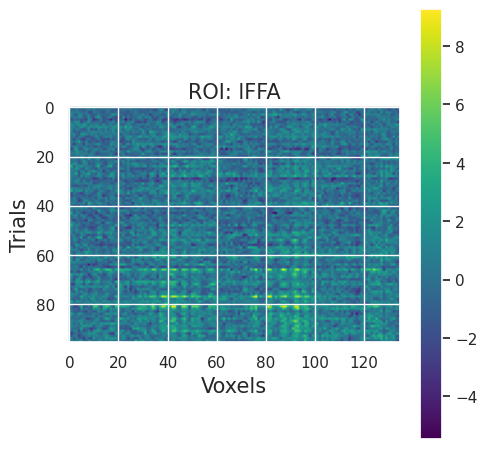

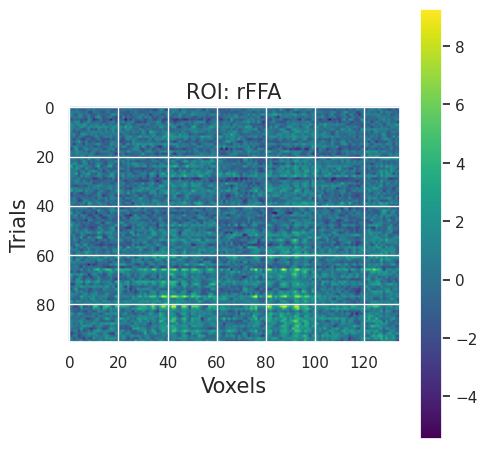

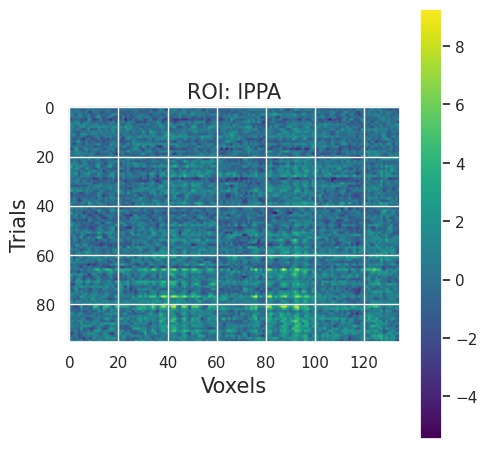

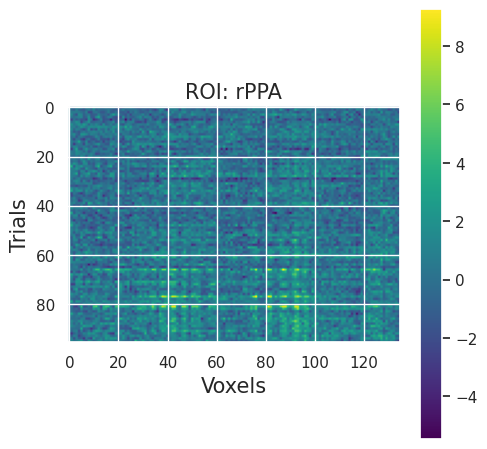

In [25]:
# Choosing ROI lFFA
roi_id_0 = 0
# Create a data matrix R
R_0=roi_data[roi_id]
#Plot it
fig, axis = plt.subplots(1,1, figsize=(5, 5))
fig.tight_layout()
plt.imshow(R,cmap='viridis')
axis.set_title("ROI: lFFA", fontsize=15)
axis.set_xlabel("Voxels", fontsize=15)
axis.set_ylabel("Trials", fontsize=15)
plt.colorbar()

# Choosing ROI rFFA
roi_id_1 = 1
# Create a data matrix R
R_1=roi_data[roi_id]
#Plot it
fig, axis = plt.subplots(1,1, figsize=(5, 5))
fig.tight_layout()
plt.imshow(R,cmap='viridis')
axis.set_title("ROI: rFFA", fontsize=15)
axis.set_xlabel("Voxels", fontsize=15)
axis.set_ylabel("Trials", fontsize=15)
plt.colorbar()

# Choosing ROI lPPA
roi_id_2 = 2
# Create a data matrix R
R_2=roi_data[roi_id]
#Plot it
fig, axis = plt.subplots(1,1, figsize=(5, 5))
fig.tight_layout()
plt.imshow(R,cmap='viridis')
axis.set_title("ROI: lPPA", fontsize=15)
axis.set_xlabel("Voxels", fontsize=15)
axis.set_ylabel("Trials", fontsize=15)
plt.colorbar()

# Choosing ROI rPPA
roi_id_3 = 3
# Create a data matrix R
R_3=roi_data[roi_id]
#Plot it
fig, axis = plt.subplots(1,1, figsize=(5, 5))
fig.tight_layout()
plt.imshow(R,cmap='viridis')
axis.set_title("ROI: rPPA", fontsize=15)
axis.set_xlabel("Voxels", fontsize=15)
axis.set_ylabel("Trials", fontsize=15)
plt.colorbar()

### Sorting the data
We want to sort in a meaningfull way, i.e., faces being close to human body parts 

In [42]:
# Add the stimulus condition labels so that we can sort the data, collecting rows from the same condition together.
#sort_ids = labels.argsort()
#rffa_sorted = roi_data[2][sort_ids, :]

In [8]:
# Add the stimulus condition labels so that we can sort the data, collecting rows from the same condition together.
new_order=('human face', 'human bodypart', 'nonhuman face', 'nonhuman bodypart', 'natural inanimate', 'artificial inanimate')

# Make a loop to make a vector of new labels
category_vec=[]
labels2=[]
for nn in range(len(labels[:92,])):
    #Make a vector with category names, rather than numeric labels
    category_vec.append(categories[int(labels[nn]-1)])
    
    # Compare current category to new order, to make a vector of labels according the the new order
    for nnn in range(len(new_order)):
        if category_vec[nn]==new_order[nnn]:
            labels2.append(nnn)

##Inspect outcome
#print(category_vec)
#print(len(labels2))

#Make a new sorting index to use for plotting
labels2=np.array(labels2)
sort_ids2 = labels2.argsort()

### Create similarity matrices
Let's examine the similarity of the neural representations of each image with the neural patterns of every other image in the dataset. If the neural patterns are similar between images, we will see high values of similarity, but if the neural patterns are dissimilar, we will see low values of similarity.

There are many ways to compute similarity. We start with one of the most common measures of similarity that you are already familiar with: Pearson correlation (see notebook-04). We compute the Pearson correlation on the neural pattern for each image with every other image. We can compute this on data for each of the ROIs that we have just loaded (left and right FFA, and left and right PPA). For each ROI, our computation will result in a 92 x 92 matrix (we only have labels for 92 images). This resulting matrix shows how similar the neural patterns of activity are between images and is called the representational similarity matrix (RSM).

#### Plotting raw similarity matrix

In [44]:
# Specify ROI
roi_id = 1

# Calculate the RSM
R=roi_data[roi_id][sort_ids2, :][:92,]
rsm = np.corrcoef(R) # only include the first 92 trials, the last 4 are NaNs.

Text(0.5, 1.0, 'Raw RSM, rFFA')

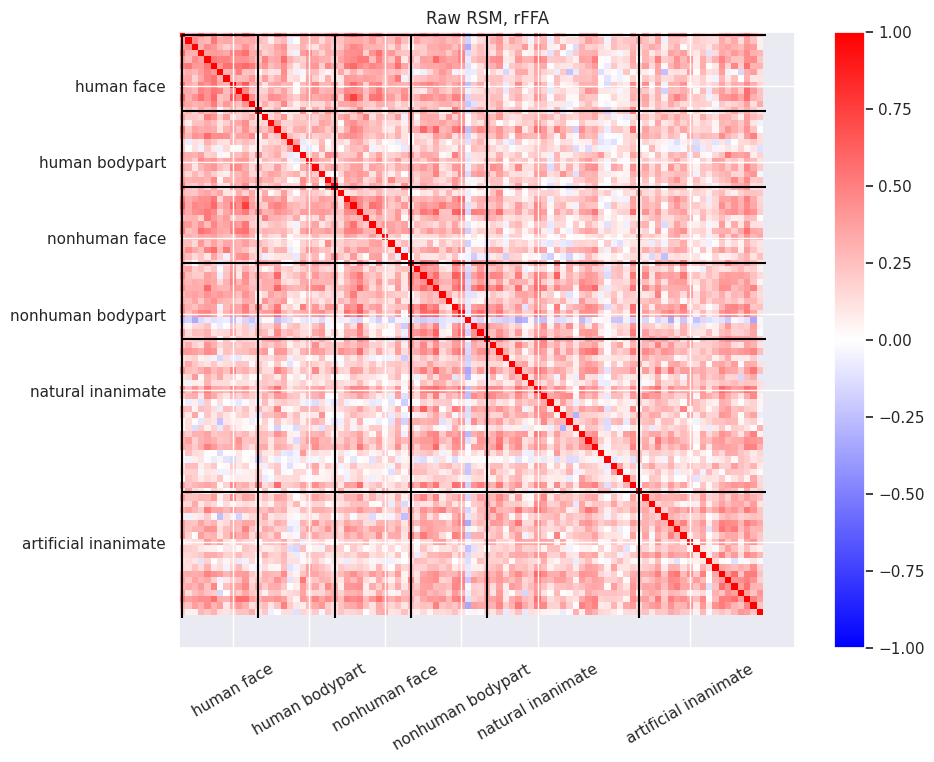

In [45]:
# Specify ROI
roi_id = 1

# Calculate the RSM
R=roi_data[roi_id][sort_ids2, :][:92,]
rsm = np.corrcoef(R) # only include the first 92 trials, the last 4 are NaNs

# Plot 
f, ax = plt.subplots(1,1, figsize=(10, 8))
plt.imshow(
    rsm, 
    cmap='bwr', 
    vmin=-1,
    vmax=1,
)
plt.colorbar()

# Pull out the bin edges between the different categories
binsize = np.histogram(labels2[:92,], 6)[0]
edges = np.concatenate([np.asarray([0]), np.cumsum(binsize)])[:-1]
ax.set_xticks(list(np.array(edges)+8))
ax.set_xticklabels(new_order, rotation = 30)
ax.set_yticks(list(np.array(edges)+8))
ax.set_yticklabels(new_order)
ax.vlines(edges, 0, 92, colors='black', linewidth=1.5)
ax.hlines(edges, 0, 92, colors='black', linewidth=1.5)
ax.set_title('Raw RSM, %s' % roi_names[roi_id])

#### Plotting binned similarity matrix

Text(0.5, 1.0, 'Binned RSM rFFA')

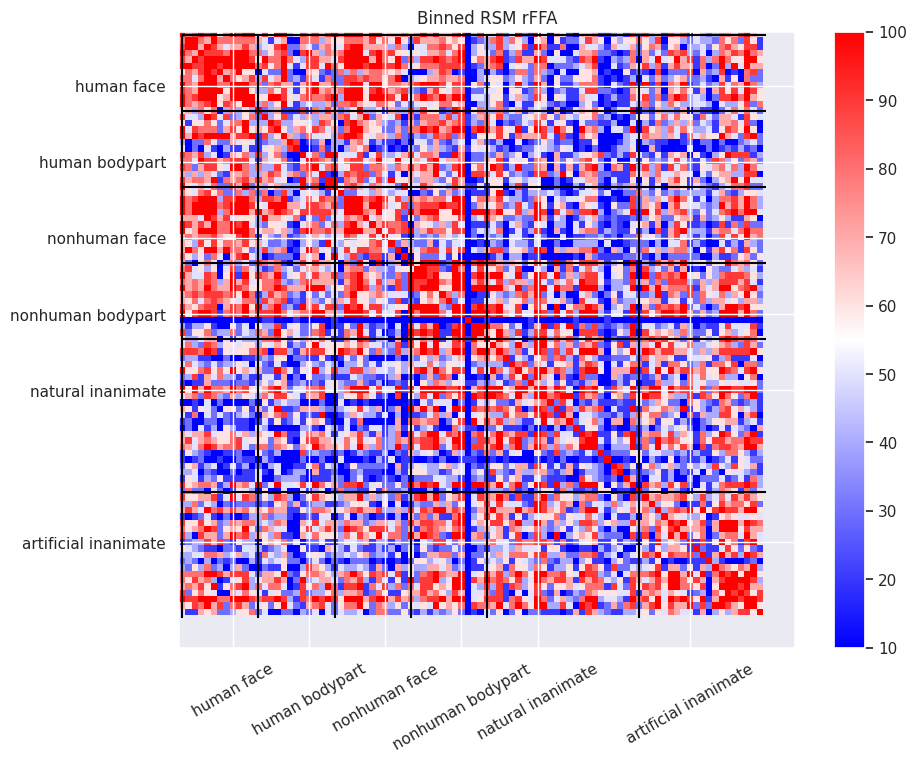

In [46]:
# Plot the digitized RSM
f, ax = plt.subplots(1,1, figsize=(10, 8))
plt.imshow(
    digitize_rdm(rsm), 
    cmap='bwr', 
)
plt.colorbar()

# Pull out the bin edges between the different categories
binsize = np.histogram(labels2[:92,], 6)[0]
edges = np.concatenate([np.asarray([0]), np.cumsum(binsize)])[:-1]
ax.set_xticks(list(np.array(edges)+8))
ax.set_xticklabels(new_order, rotation = 30)
ax.set_yticks(list(np.array(edges)+8))
ax.set_yticklabels(new_order)
ax.vlines(edges, 0, 92, colors='black', linewidth=1.5)
ax.hlines(edges, 0, 92, colors='black', linewidth=1.5)
ax.set_title('Binned RSM %s' % roi_names[roi_id])

### Create dissimilarity matrices
This close cousin of the similarity matrix is called the representational dissimilarity matrix (RDM). The dissimilarity matrix can be computed as 1 - correlation.

In [47]:
# Calculate the RSM
R=roi_data[roi_id][sort_ids2, :][:92,]
rdm = 1-np.corrcoef(R) # only include the first 92 trials, the last 4 are NaNs.

#### Plotting raw dissimilarity matrix

Text(0.5, 1.0, 'Raw RDM, rFFA')

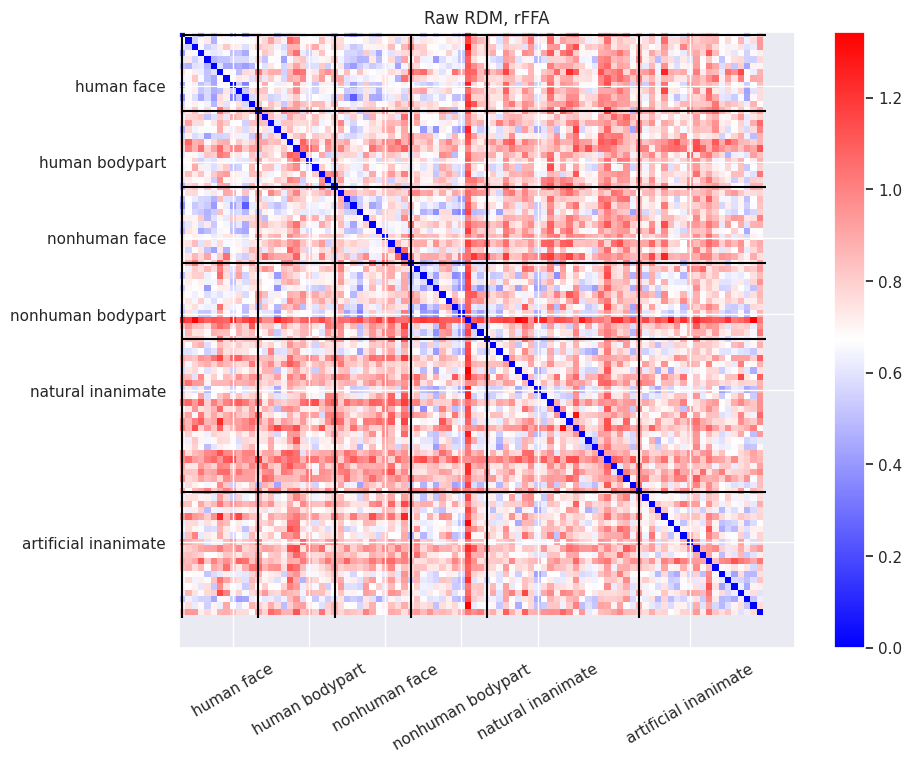

In [48]:
# Plot 
f, ax = plt.subplots(1,1, figsize=(10, 8))
plt.imshow(
    rdm, 
    cmap='bwr', 
    
)
plt.colorbar()

# Pull out the bin edges between the different categories
binsize = np.histogram(labels2[:92,], 6)[0]
edges = np.concatenate([np.asarray([0]), np.cumsum(binsize)])[:-1]
ax.set_xticks(list(np.array(edges)+8))
ax.set_xticklabels(new_order, rotation = 30)
ax.set_yticks(list(np.array(edges)+8))
ax.set_yticklabels(new_order)
ax.vlines(edges, 0, 92, colors='black', linewidth=1.5)
ax.hlines(edges, 0, 92, colors='black', linewidth=1.5)
ax.set_title('Raw RDM, %s' % roi_names[roi_id])

#### Plotting binned dissimilarity matrix

Text(0.5, 1.0, 'Binned RDM, rFFA')

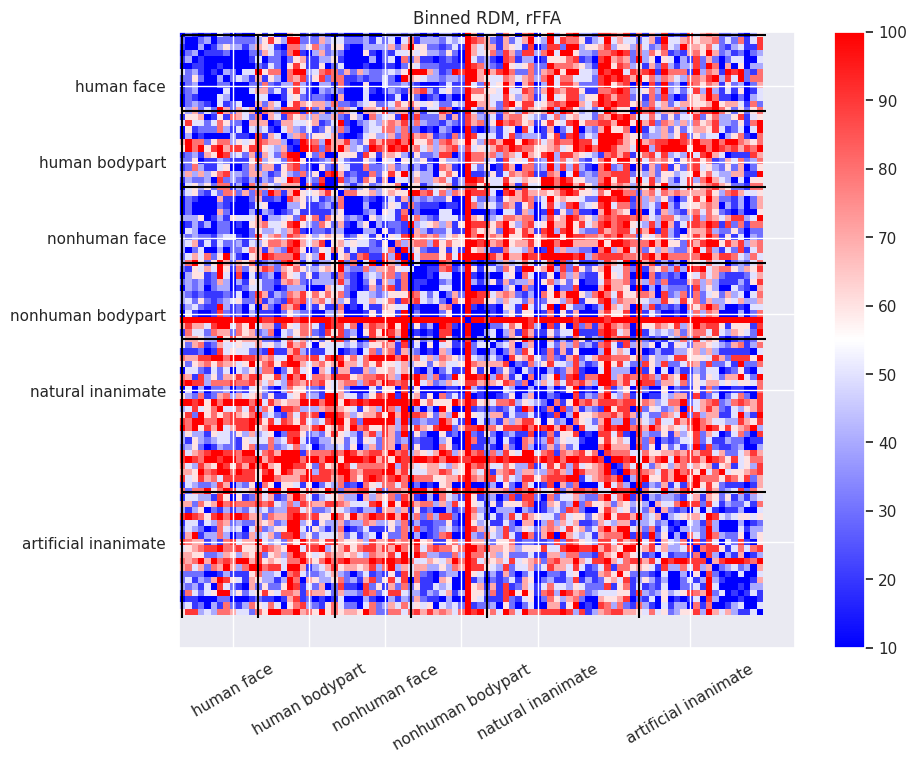

In [49]:
# Plot the digitized RSM
f, ax = plt.subplots(1,1, figsize=(10, 8))
plt.imshow(
    digitize_rdm(rdm), 
    cmap='bwr', 
)
plt.colorbar()

# Pull out the bin edges between the different categories
binsize = np.histogram(labels2[:92,], 6)[0]
edges = np.concatenate([np.asarray([0]), np.cumsum(binsize)])[:-1]
ax.set_xticks(list(np.array(edges)+8))
ax.set_xticklabels(new_order, rotation = 30)
ax.set_yticks(list(np.array(edges)+8))
ax.set_yticklabels(new_order)
ax.vlines(edges, 0, 92, colors='black', linewidth=1.5)
ax.hlines(edges, 0, 92, colors='black', linewidth=1.5)
ax.set_title('Binned RDM, %s' % roi_names[roi_id])

## Creating cosine matrices

### Raw dissimilarity

Text(0.5, 1.0, 'Raw RDM (cosine distance), rFFA')

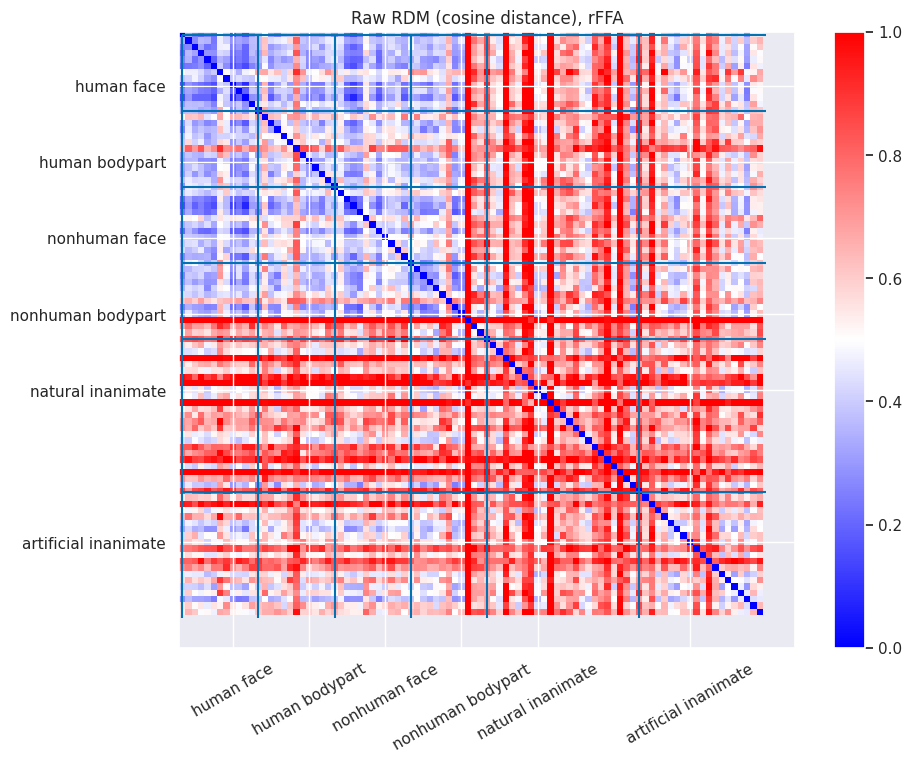

In [50]:
# Calculate the RDM
rdm_cos = pairwise_distances(R, metric='cosine')

# Plot 
f, ax = plt.subplots(1,1, figsize=(10, 8))
plt.imshow(
    rdm_cos, 
    cmap='bwr', 
    vmin=0,
    vmax=1,
)
plt.colorbar()

# Pull out the bin edges between the different categories
binsize = np.histogram(labels2[:92,], 6)[0]
edges = np.concatenate([np.asarray([0]), np.cumsum(binsize)])[:-1]
ax.set_xticks(list(np.array(edges)+8))
ax.set_xticklabels(new_order, rotation = 30)
ax.set_yticks(list(np.array(edges)+8))
ax.set_yticklabels(new_order)
ax.vlines(edges,0,92)
ax.hlines(edges,0,92)
ax.set_title('Raw RDM (cosine distance), %s' % roi_names[roi_id])

### Binned dissimilarity

Text(0.5, 1.0, 'Binned RDM (cosine distance), rPPA')

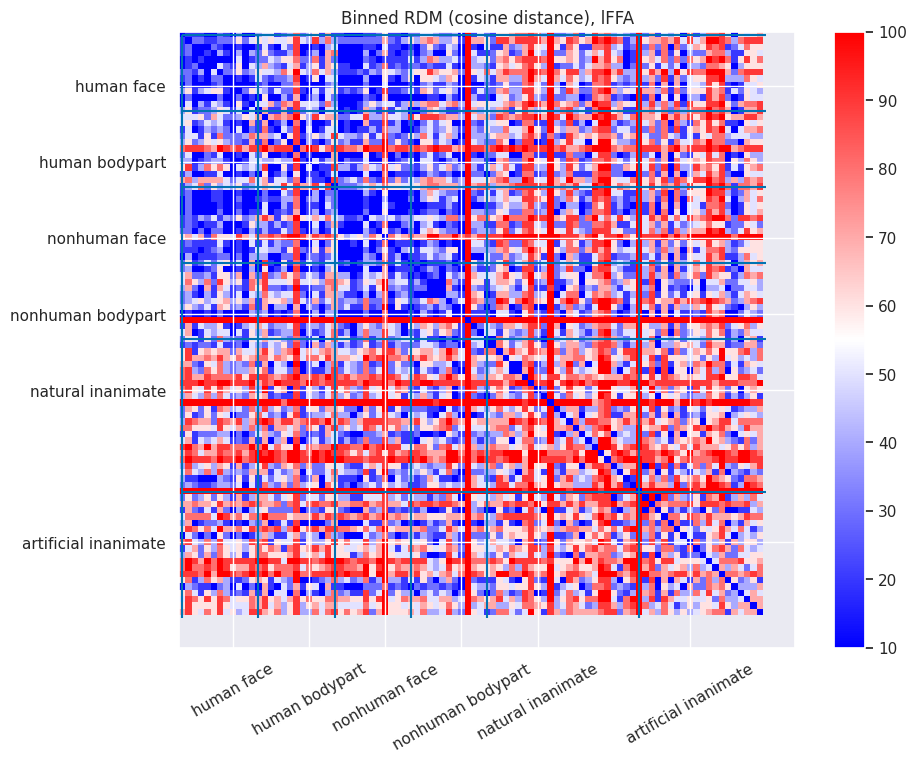

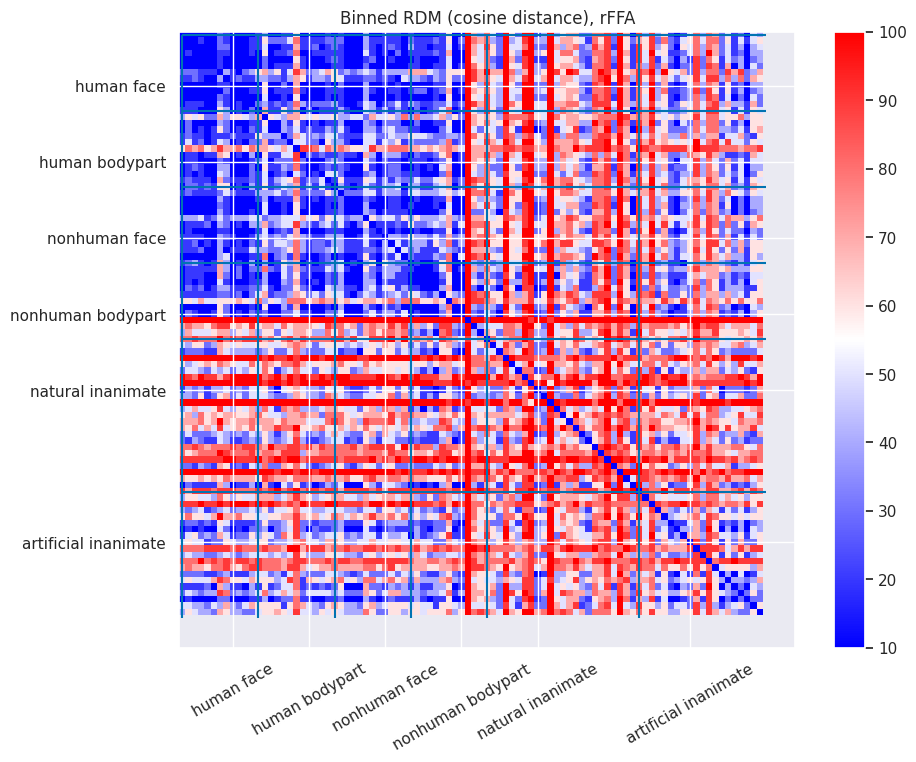

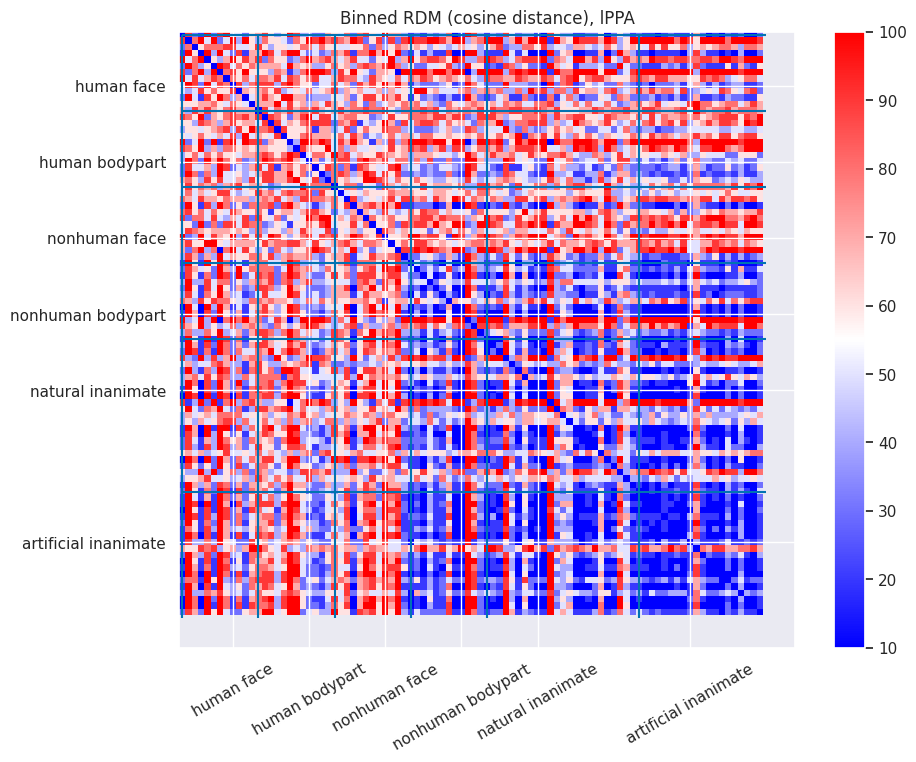

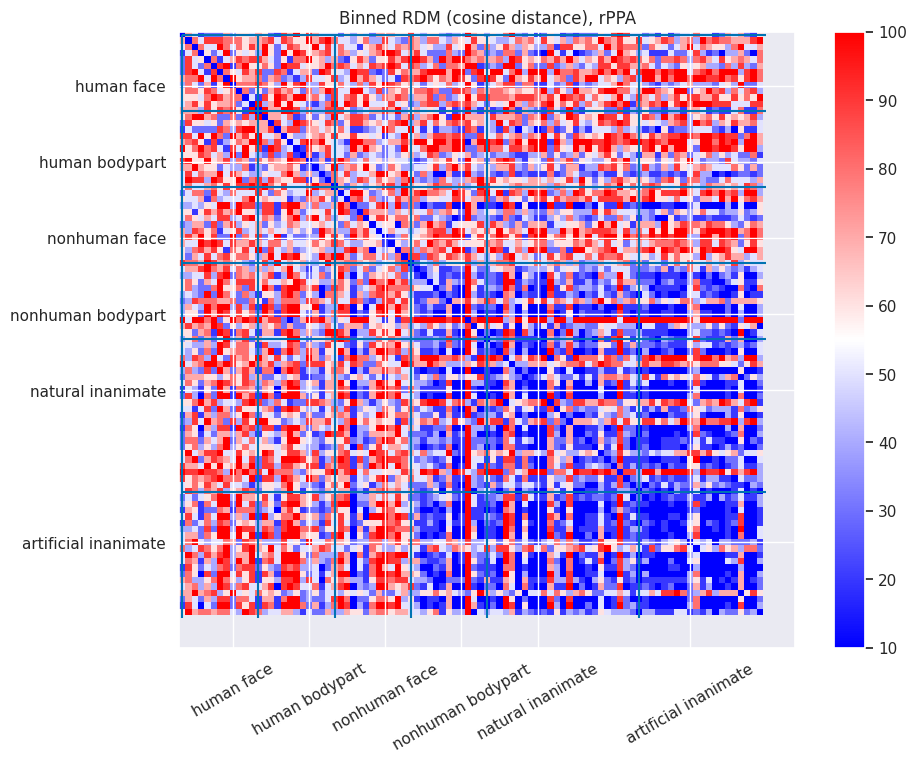

In [32]:
######### lFFA #########
roi_id= 0
rdm_cos_0 = pairwise_distances(R_0, metric='cosine')

# plot
f, ax = plt.subplots(1,1, figsize=(10, 8))
plt.imshow(
    digitize_rdm(rdm_cos_0), 
    cmap='bwr',
)
plt.colorbar()

# Pull out the bin edges between the different categories
binsize = np.histogram(labels2[:92,], 6)[0]
edges = np.concatenate([np.asarray([0]), np.cumsum(binsize)])[:-1]
ax.set_xticks(list(np.array(edges)+8))
ax.set_xticklabels(new_order, rotation = 30)
ax.set_yticks(list(np.array(edges)+8))
ax.set_yticklabels(new_order)
ax.vlines(edges,0,92)
ax.hlines(edges,0,92)
ax.set_title('Binned RDM (cosine distance), %s' % roi_names[roi_id])

######### rFFA #########
roi_id= 1
rdm_cos_1 = pairwise_distances(R_1, metric='cosine')

# plot
f, ax = plt.subplots(1,1, figsize=(10, 8))
plt.imshow(
    digitize_rdm(rdm_cos_1), 
    cmap='bwr', 
)
plt.colorbar()

# Pull out the bin edges between the different categories
binsize = np.histogram(labels2[:92,], 6)[0]
edges = np.concatenate([np.asarray([0]), np.cumsum(binsize)])[:-1]
ax.set_xticks(list(np.array(edges)+8))
ax.set_xticklabels(new_order, rotation = 30)
ax.set_yticks(list(np.array(edges)+8))
ax.set_yticklabels(new_order)
ax.vlines(edges,0,92)
ax.hlines(edges,0,92)
ax.set_title('Binned RDM (cosine distance), %s' % roi_names[roi_id])

######### lPPA #########
roi_id= 2
rdm_cos_2 = pairwise_distances(R_2, metric='cosine')

# plot
f, ax = plt.subplots(1,1, figsize=(10, 8))
plt.imshow(
    digitize_rdm(rdm_cos_2), 
    cmap='bwr', 
)
plt.colorbar()

# Pull out the bin edges between the different categories
binsize = np.histogram(labels2[:92,], 6)[0]
edges = np.concatenate([np.asarray([0]), np.cumsum(binsize)])[:-1]
ax.set_xticks(list(np.array(edges)+8))
ax.set_xticklabels(new_order, rotation = 30)
ax.set_yticks(list(np.array(edges)+8))
ax.set_yticklabels(new_order)
ax.vlines(edges,0,92)
ax.hlines(edges,0,92)
ax.set_title('Binned RDM (cosine distance), %s' % roi_names[roi_id])

######### rPPA #########
roi_id= 3
rdm_cos_3 = pairwise_distances(R_3, metric='cosine')

# plot
f, ax = plt.subplots(1,1, figsize=(10, 8))
plt.imshow(
    digitize_rdm(rdm_cos_3), 
    cmap='bwr', 
)
plt.colorbar()

# Pull out the bin edges between the different categories
binsize = np.histogram(labels2[:92,], 6)[0]
edges = np.concatenate([np.asarray([0]), np.cumsum(binsize)])[:-1]
ax.set_xticks(list(np.array(edges)+8))
ax.set_xticklabels(new_order, rotation = 30)
ax.set_yticks(list(np.array(edges)+8))
ax.set_yticklabels(new_order)
ax.vlines(edges,0,92)
ax.hlines(edges,0,92)
ax.set_title('Binned RDM (cosine distance), %s' % roi_names[roi_id])

### Evaluating the fit of the RDMs and RSMs using correlation testing
Alright, so now we got two RDMs: the feature RDM and the neural RDM. To evaluate to what extent the two RDMs share the same representational geometry, we can simply correlate them! Before doing so, we have to do one more thing: extract the lower (or upper) triangle of the RDM. This is because RDMs are symmetric: the values above and below the diagonal are exactly the same. If we used the entire (flattened) RDM, we'd "artifically" create twice as many datapoints (i.e. the pairwise dissimilarities) than there really are, which will inflate the significance of the correlation between the RDMs because of increased sample size. So, instead of using all $N\cdot N$ pairwise differences from the RDM, we need to extract only the flattened $N\times (N-1)/2$ pairwise dissimilarity values, the "representational dissimilarity vector" (RDV) if you will. This means that we do not include the diagonal!

Fortunately, there is a function that easily extracts the lower triangle of a square distance matrix: `squareform` (from the `scipy.spatial.distance` module):

In [40]:
# Let's extract the RDV from lFFA
rdv_cos_0 = squareform(rdm_cos_0.round(5))
print("Shape rdv_cos:", rdv_cos_0.shape)

# Let's extract the RDV from rFFA
rdv_cos_1 = squareform(rdm_cos_1.round(5))
print("Shape rdv_cos:", rdv_cos_1.shape)

# Let's extract the RDV from lPPA
rdv_cos_2 = squareform(rdm_cos_2.round(5))
print("Shape rdv_cos:", rdv_cos_2.shape)

# Let's extract the RDV from rPPA
rdv_cos_3 = squareform(rdm_cos_3.round(5))
print("Shape rdv_cos:", rdv_cos_2.shape)

Shape rdv_cos: (4186,)
Shape rdv_cos: (4186,)
Shape rdv_cos: (4186,)
Shape rdv_cos: (4186,)


Importantly, the correlation between feature and neural RDMs is often evaluated using a rank-based correlation metric. For continuous feature RDMs, this is usually the Spearman correlation, but for categorical feature RDMs (such as our model RDMs), often the "Kendall Tau $\alpha$" correlation is used, as it deals properly with tied ranks. Implementations of both correlations are available from the `scipy.stats` module. Here, we'll use Kendall's Tau $\alpha$, because our model RDMs are categorical:

In [42]:
# Correlation between left and right FFA
rdm_FFA_corr, pval = kendalltau(rdv_cos_0, rdv_cos_1)
print("Correlation between RDM for lFFA and RDM for rFFA (p-value): %.3f (%.3f)" % (rdm_FFA_corr, pval))

# Correlation between left and right PPA
rdm_PPA_corr, pval = kendalltau(rdv_cos_2, rdv_cos_3)
print("Correlation between RDM for lPPA and RDM for rPPA (p-value): %.3f (%.3f)" % (rdm_PPA_corr, pval))

Correlation between RDM for lFFA and RDM for rFFA (p-value): 0.417 (0.000)
Correlation between RDM for lPPA and RDM for rPPA (p-value): 0.437 (0.000)


In [43]:
# Correlation between left FFA and left PPA
rdm_FFA_corr, pval = kendalltau(rdv_cos_0, rdv_cos_2)
print("Correlation between RDM for lFFA and RDM for lPPA (p-value): %.3f (%.3f)" % (rdm_FFA_corr, pval))

# Correlation between right FFA and right PPA
rdm_PPA_corr, pval = kendalltau(rdv_cos_1, rdv_cos_3)
print("Correlation between RDM for rFFA and RDM for rPPA (p-value): %.3f (%.3f)" % (rdm_PPA_corr, pval))

Correlation between RDM for lFFA and RDM for lPPA (p-value): 0.079 (0.000)
Correlation between RDM for rFFA and RDM for rPPA (p-value): 0.060 (0.000)


In [45]:
# Correlation between left FFA and right PPA
rdm_FFA_corr, pval = kendalltau(rdv_cos_0, rdv_cos_3)
print("Correlation between RDM for lFFA and RDM for rPPA (p-value): %.3f (%.3f)" % (rdm_FFA_corr, pval))

# Correlation between right FFA and left PPA
rdm_PPA_corr, pval = kendalltau(rdv_cos_1, rdv_cos_2)
print("Correlation between RDM for rFFA and RDM for lPPA (p-value): %.3f (%.3f)" % (rdm_PPA_corr, pval))

Correlation between RDM for lFFA and RDM for rPPA (p-value): 0.052 (0.000)
Correlation between RDM for rFFA and RDM for lPPA (p-value): 0.081 (0.000)
